<a href="https://colab.research.google.com/github/machiwao/CCMACLRL_PROJECT_COM222/blob/main/project_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Shopee Computer Product Reviews

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [2]:
df = pd.read_csv("hf://datasets/magixxixx/shopee-product-reviews-on-computer-category/combined-dataset-shuffled-cased-40K.csv")
df_test_1 = pd.read_csv("hf://datasets/ccosme/SentiTaglishProductsAndServices/SentiTaglish_ProductsAndServices.csv")

splits = {'train': 'FiReCS_train_set.csv', 'test': 'FiReCS_test_set.csv'}
df_test_2 = pd.read_csv("hf://datasets/ccosme/FiReCS/" + splits["train"])

### Training Data

In [3]:
df.head()

,text,sentiment
0,mali yung dineliver 2l order ko naging 1l bulok!,0
1,xl order ko dumating large.nkalagay sa sticker...,0
2,"sobrang bilis ma lowbat, hindi masyado nakaka ...",0
3,first time ko umorder dito. di naman gumagana ...,0
4,"not well packed, wala itong box. hindi sya ma ...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
df.duplicated().sum()

1

In [7]:
df['sentiment'].value_counts()

sentiment
0    20000
1    20000
Name: count, dtype: int64

### Testing Data

In [8]:
# Leave only sentiments with 1 (Negative) and 3(Positive) for df_test_1
# Map 1 to 0 and 3 to 1 to be consistent with training dataset
df_test_1 = df_test_1[df_test_1['sentiment'].isin([1, 3])]
df_test_1['sentiment'] = df_test_1['sentiment'].map({1: 0, 3: 1})

In [9]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6851 entries, 0 to 10509
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     6851 non-null   object
 1   sentiment  6851 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 160.6+ KB


In [10]:
df_test_1.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df_test_1.duplicated().sum()

2

In [12]:
df_test_1['sentiment'].value_counts()

sentiment
1    3443
0    3408
Name: count, dtype: int64

In [13]:
df_test_1.rename(columns={'review': 'text'}, inplace=True)

In [14]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  7340 non-null   object 
 1   label   7340 non-null   float64
dtypes: float64(1), object(1)
memory usage: 114.8+ KB


In [15]:
#Leave only sentiments with 0(Negative) and 2(Positive) for df_test_2
# Map 2 to 1 to be consistent with training dataset
df_test_2 = df_test_2[df_test_2['label'].isin([0.0, 2.0])]
df_test_2['label'] = df_test_2['label'].map({0.0: 0,2.0: 1})

In [16]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4791 entries, 0 to 7338
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  4791 non-null   object
 1   label   4791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.3+ KB


In [17]:
df_test_2.rename(columns={'review': 'text', 'label': 'sentiment'}, inplace=True)

In [18]:
df_test = pd.concat([df_test_1, df_test_2])

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11642 entries, 0 to 7338
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       11642 non-null  object
 1   sentiment  11642 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 272.9+ KB


In [20]:
df_test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [21]:
df_test.duplicated().sum()

848

## Data Preprocessing

In [22]:
df.drop_duplicates(inplace = True)
df_test.drop_duplicates(inplace = True)

In [23]:
# remove stopwords
filipino_stopwords = set([
      'akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano',
      'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago',
      'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito',
      'doon', 'eh', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang',
      'gumawa', 'gusto', 'ha', 'habang', 'hanggang', 'hindi', 'huwag', 'hoy',
      'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan',
      'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyang','iyong', 'ka',
      'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang',
      'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan',
      'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang',
      'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari',
      'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat',
      'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na',
      'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'nang',
      'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ngunit', 'ni', 'nila', 'nilang',
      'nito', 'niya', 'niyang', 'noon', 'o', 'pa', 'paano', 'pababa',
      'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'pala', 'palabas',
      'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho',
      'pataas', 'pero', 'po', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi',
      'sabihin', 'sarili', 'sila', 'sino', 'siya',
      'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang', 'yan', 'yung', 'username'
  ])
english_stopwords = set(stopwords.words('english'))
combined_stopwords = filipino_stopwords.union(english_stopwords)

In [24]:
def preprocess_text(text):
  '''  # Convert to lowercase
  text = text.lower()
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)
  text = re.sub(r'\d+', '', text)'''

  text = re.sub(r"\n","", text)   #remove line breaks
  text = text.lower() #convert to lowercase
  text = re.sub(r"\d+","",text)   #remove digits and currencies
  text = re.sub(r'[\$\d+\d+\$]', "", text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
  text = re.sub(r'[^\w\s]','',text)   #remove punctuation
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks


  text = ' '.join([word for word in text.split() if word not in combined_stopwords])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Blix\AppData\Local\Temp\ipykernel_2392\2195482319.py:2: SyntaxWarning: invalid escape sequence '\S'
  '''  # Convert to lowercase


In [25]:
df['text'] = df['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

## Training the Model

In [26]:
X_train = df['text']
y_train = df['sentiment']
X_test = df_test['text']
y_test = df_test['sentiment']

In [27]:
combined_stopwords_list = list(combined_stopwords)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5, stop_words=combined_stopwords_list)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [28]:
X_train_transformed.shape

(39999, 22476)

In [29]:
from sklearn.svm import SVC

model = SVC()

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    return accuracy, report, disp

# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    accuracy, report, disp = train_and_evaluate_model(model, X_train_transformed, y_train, X_test_transformed, y_test)
    print(f"{model_name}:\nAccuracy: {accuracy}\nReport:\n{report}\nConfusion Matrix:\n{disp.confusion_matrix}\n")

Naive Bayes:
Accuracy: 0.7960904206040392
Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      5418
           1       0.90      0.66      0.76      5376

    accuracy                           0.80     10794
   macro avg       0.82      0.80      0.79     10794
weighted avg       0.82      0.80      0.79     10794

Confusion Matrix:
[[5022  396]
 [1805 3571]]

Logistic Regression:
Accuracy: 0.8506577728367611
Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      5418
           1       0.94      0.75      0.83      5376

    accuracy                           0.85     10794
   macro avg       0.87      0.85      0.85     10794
weighted avg       0.87      0.85      0.85     10794

Confusion Matrix:
[[5157  261]
 [1351 4025]]



## Hyperparameterization and Cross-validation

In [30]:
param_grid = {
    'C': [0.1, 1, 5, 10, 100],
    'kernel': ['linear'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale','auto']
}

In [31]:
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, n_jobs = -1, return_train_score=True, verbose=0)
# Train with grid search
grid.fit(X_train_transformed, y_train)

# Access cv_results_ to extract scores
cv_results = grid.cv_results_

# Iterate over all combinations of parameters
for i in range(len(cv_results['params'])):
    print(f"Iteration {i+1}:")
    print(f"Parameters: {cv_results['params'][i]}")

    # Train accuracy for this iteration
    train_acc = cv_results['mean_train_score'][i]
    print(f"Train Accuracy: {train_acc:.4f}")

    # Test accuracy for this iteration (mean cross-validated test score)
    test_acc = cv_results['mean_test_score'][i]
    print(f"Test Accuracy: {test_acc:.4f}")
    print('-' * 50)

Iteration 1:
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
--------------------------------------------------
Iteration 2:
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
--------------------------------------------------
Iteration 3:
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
--------------------------------------------------
Iteration 4:
Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
--------------------------------------------------
Iteration 5:
Parameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
--------------------------------------------------
Iteration 6:
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Train Accuracy: 0.9671
Test Accuracy: 0.9606
-----------------------------------------------

In [32]:
# Best parameters
print("Best Parameters: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best Estimator:  SVC(C=1, gamma=1, kernel='linear')


In [30]:
# Chosen Model
model = SVC(C = 1, gamma = 1, kernel='linear')
model.fit(X_train_transformed, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [31]:
y_pred = model.predict(X_test_transformed)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      5418
           1       0.94      0.76      0.84      5376

    accuracy                           0.86     10794
   macro avg       0.87      0.86      0.85     10794
weighted avg       0.87      0.86      0.85     10794

0.8558458402816379


In [39]:
# Cross Validation
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
X_transformed = vectorizer.fit_transform(X)


from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())

[0.96859927 0.96800866 0.96476031 0.96495373 0.8783225 ]
0.9489288960770839
0.035337381702557666


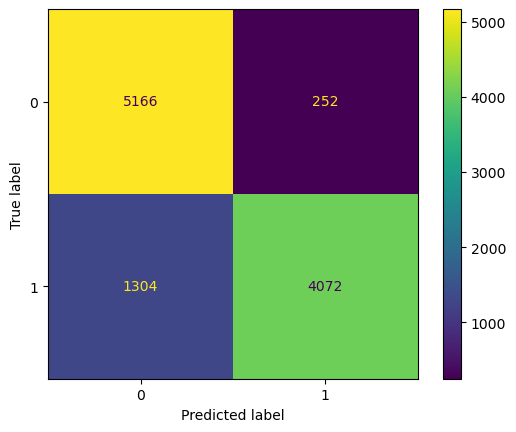

In [32]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [33]:
input_text = pd.Series("Ang bilis ng delivery kaso pagdating sakin di naman gumagana, solid")
input_text = input_text.apply(preprocess_text)
input_text_transform = vectorizer.transform(input_text)
prediction = model.predict(input_text_transform)
prediction

array([1], dtype=int64)

In [34]:
input_texts = ['This shit is so damn good product',
               'Hindi niyo ako maloloko! Original to noh? Ang ganda!',
               'Tangina good shit!', 'Tagal niya dumating pero ang solid hahaha',
               'Ito na yon? Hindi man lang tumagal.', 'Anggggg gandaaaaaa.',
               'Angggggggg lupittttttt sulitttttt baaaaayaaaaaadd tttttaaaaaeeeeeenaaaaa!',
               'Tangina ang tagal ko itong hinintay ka-excite gamitin maganda raw eh hehe',
               "Ang bilis ng delivery kaso pagdating sakin di naman gumagana, solid"]

In [35]:
for text in input_texts:
  input_text = pd.Series(text)
  input_text = input_text.apply(preprocess_text)
  input_text_transform = vectorizer.transform(input_text)
  prediction = model.predict(input_text_transform)
  if prediction == 0:
    print(f"Review: {text} -> Sentiment: Bad")
  else:
    print(f"Review: {text} -> Sentiment: Good")

Review: This shit is so damn good product -> Sentiment: Good
Review: Hindi niyo ako maloloko! Original to noh? Ang ganda! -> Sentiment: Good
Review: Tangina good shit! -> Sentiment: Good
Review: Tagal niya dumating pero ang solid hahaha -> Sentiment: Good
Review: Ito na yon? Hindi man lang tumagal. -> Sentiment: Bad
Review: Anggggg gandaaaaaa. -> Sentiment: Bad
Review: Angggggggg lupittttttt sulitttttt baaaaayaaaaaadd tttttaaaaaeeeeeenaaaaa! -> Sentiment: Bad
Review: Tangina ang tagal ko itong hinintay ka-excite gamitin maganda raw eh hehe -> Sentiment: Bad
Review: Ang bilis ng delivery kaso pagdating sakin di naman gumagana, solid -> Sentiment: Good
